# ISING MODEL

The process will be similar to that of the SYK model, only differing in the Hamiltonian and maybe the initial state of the system.

Therefore, the first part of this notebook, will be all the functions that's required to run the code.

In [5]:
import numpy as np
import math
from scipy.linalg import expm, eig
from itertools import combinations

In [6]:
def Entanglement_Entropy_COMBINED_uniform(normalized_statevector, n_A=1):
    PT_matrix_uniform = np.array([[Partial_Trace_Subsystem_B_v3(normalized_statevector, n_A, i+1, j+1) for j in range(2**n_A)] for i in range(2**n_A)])
    eigenval_PT_nA, eigenvec_PT_nA = np.linalg.eig(PT_matrix_uniform)
    EE_final_result = Entanglement_Entropy_lambda(eigenval_PT_nA)
    return EE_final_result

In [7]:
def Partial_Trace_Subsystem_B_v3(normalized_matrix, n_A, i, k):
    result = 0
    n_B = int(np.log2(len(normalized_matrix)) - n_A)
    for j in range(1, 2**n_B):
        result += Density_Matrix_Psi_AB_v2(normalized_matrix, n_A, i, j, k, j)
    return result[0]

In [8]:
def Density_Matrix_Psi_AB_v2(normalized_matrix, n_A, i, j, k, l):
    dense_matrix = Psi_indexed_v2(normalized_matrix, n_A, i, j) * Psi_indexed_conjugate_v2(normalized_matrix, n_A, k, l)
    return dense_matrix

In [9]:
def Psi_indexed_conjugate_v2(normalized_matrix, n_A, k, l):
    n_B = int(np.log2(len(normalized_matrix)) - n_A)
    if isinstance(k, int) and k > 0 and k <= 2**n_A and isinstance(l, int) and l > 0 and l <= 2**n_B:
        return np.conjugate(normalized_matrix[(k - 1) * 2**n_B + (l - 1)])
    else:
        return ValueError("Indices are out of bounds or not integers")

In [10]:
def Psi_indexed_v2(normalized_matrix, n_A, i, j):
    n_B = int(np.log2(len(normalized_matrix)) - n_A)
    if isinstance(i, int) and i > 0 and i <= 2**n_A and isinstance(j, int) and j > 0 and j <= 2**n_B:
        return normalized_matrix[(i - 1) * 2**n_B + (j - 1)]
    else:
        return ValueError("Indices are out of bounds or not integers")

In [11]:
def Entanglement_Entropy_lambda(eigenvalues_input):
    sum_of_EE = 0
    #epsilon = 1e-14
    for i in eigenvalues_input:
        if i > 0 :  # Ensure we don't take the log of zero
            lambda_log_lambda = i * np.log(i)
            sum_of_EE += lambda_log_lambda

    entropy = -sum_of_EE

    # Replace NaN or -inf with 0
    if np.isnan(entropy) or np.isinf(entropy):
        entropy = 0

    return entropy

In [12]:
import matplotlib.pyplot as plt
def plot_EE_vs_time(time_steps, EE_values):
    plt.figure(figsize=(10, 6))
    plt.plot(time_steps, EE_values, marker='o', linestyle='-', color='b')
    plt.xlabel('Time Steps')
    plt.ylabel('Entanglement Entropy (EE)')
    plt.title('Entanglement Entropy vs Time steps for ISING Model')
    plt.grid(True)
    plt.show()

And now the only functions we need to figure out, is the Hamiltonian and then the unitary operator function

In this model, we simply assume that the interaction occurs between neighbouring spins thats sometimes called the exchange interaction. Assume an insulator that will limit the model by implying that electron does not hop from one atoms to the other.

$$
\mathcal{H}_{ising} = -\frac{1}{2} \sum_{i,j} J_{ij} \vec{S}_i \cdot \vec{S}_j + \sum_{i} g\mu_B \vec{B}\cdot\vec{S}_i,
$$

where $J_{ij}$ is the exchange constant where when the constant is positive then it's lower energy when spins $i$ and $j$ are aligned and vice versa for the opposite. $\vec{S}_{i,j}$ here are the spins of atoms $i$ and $j$, $g$ and $\mu_B$ as the Lande g-factor and the magnetic Bohr magneton ($\mu_B = e\hbar/2m_ec$) that will characterize how much the external magnetic field will affect the system's spin. And $B$ represents the external magnetic field strength applied to the system. Natürlich we can always take an approximation of $B=0$ to simplify the model.

Random notes :

-   Spin magnetic moment

$$
\vec{\mu}_s = -g_s \mu_B \frac{\vec{S}}{\hbar}
$$

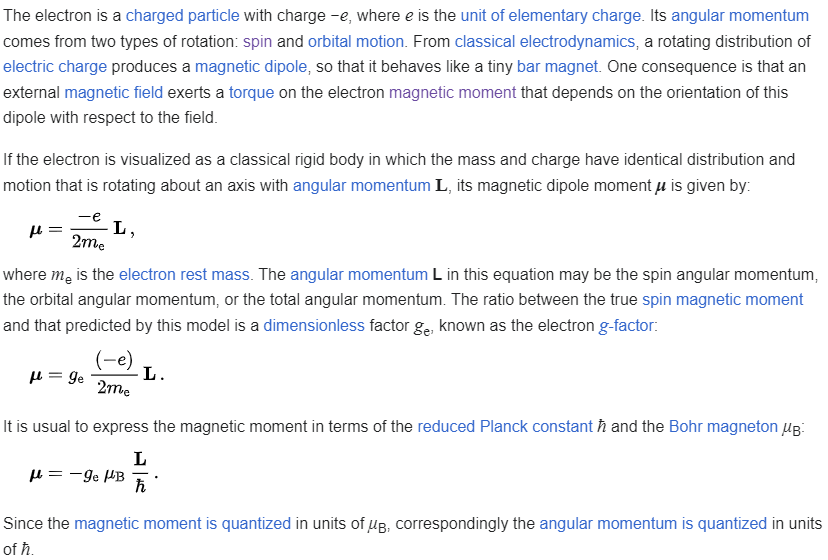

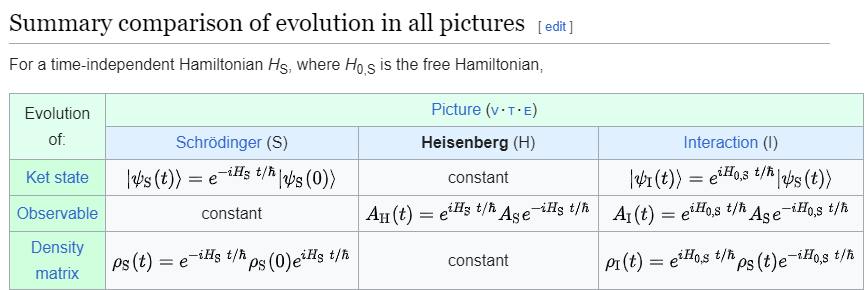

https://en.wikipedia.org/wiki/Ehrenfest_theorem


Note from a Lecture note by Yunfeng Jiang

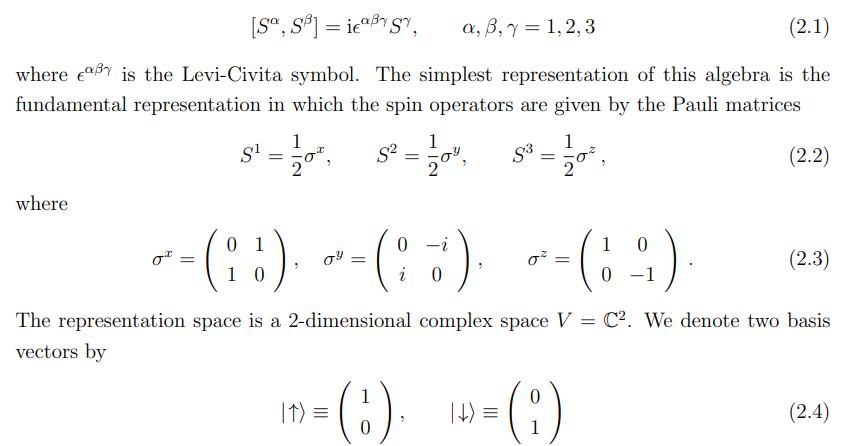

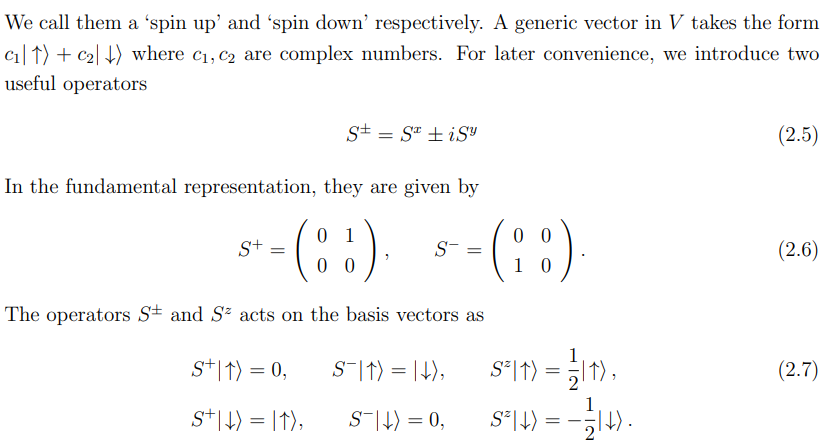

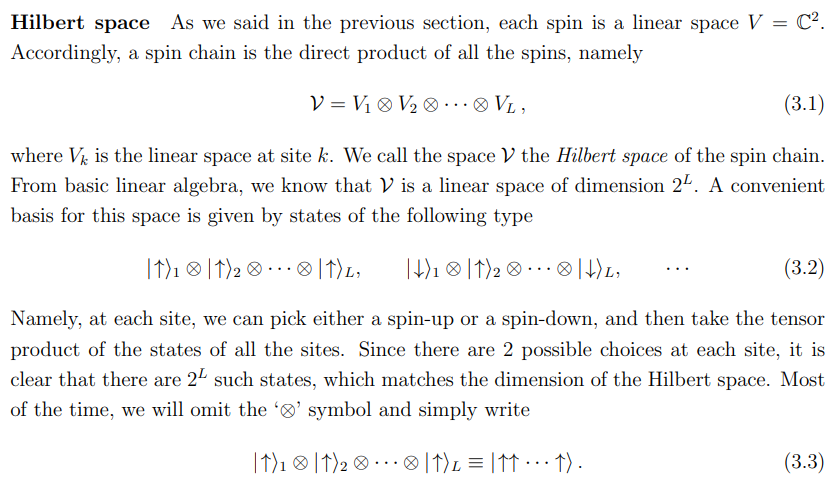

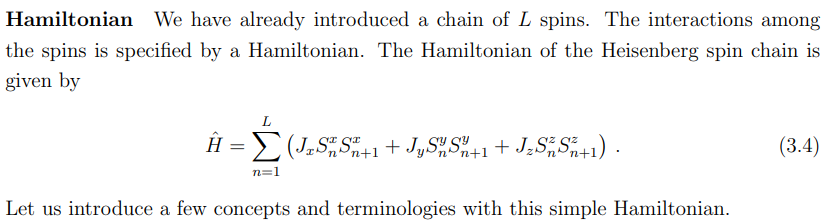

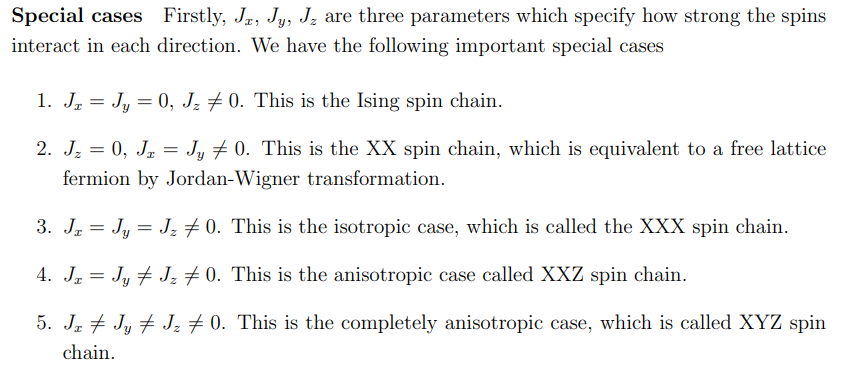

In [13]:
# Pauli Matrices

PauliX = np.array([[0, 1],[1, 0]])

PauliY = np.array([[0, -1j],[1j, 0]])

PauliZ = np.array([[1, 0],[0, -1]])

IdMatrix = np.eye(2)

Here we will assume the most simple case of 1 dimensional Ising chain, where the last term of $\sigma_{n+1} = \sigma_{1}$, with a finite number of spins. I will also add an external magnetic term, where you can choose to input the strength of the magnetic field in the function `Hamiltonian_ISING`.

We will choose the direction of the spin towards $x$ axis and the external magnetic field towards the $z$ axis,

$$
H_{ising} = \sum_{i=1}^{n} \sigma_{i}^{x}\sigma_{i+1}^{x} + \lambda\sum_{i=1}^{n} \sigma_{i}^{z}
$$


In [14]:
import numpy as np
from scipy.linalg import kron
from scipy.sparse import csr_matrix

Note :

- I dont think its a kronecker product.

lets see, If we limit the system to only 4 spin chain, then the initial state could be written as follows,

$$
\ket{0000} = \ket{0} \otimes\ket{0} \otimes\ket{0} \otimes\ket{0},
$$
which can be written as a column vector with a size of $2^n$ because,

$$
\ket{0} = \begin{pmatrix} 1 \\ 0\end{pmatrix}.
$$


The spin are defined as,
$$
S_{x,y,z} = \frac{1}{2} \sigma_{x,y,z},
$$
which follows the $\mathcal{su}(2)$ algebra, satisfying the following commutation relations,

$$
[S^\alpha, S^\beta] = i\epsilon^{\alpha \beta \gamma} S^\gamma,
$$
where $\alpha, \beta, \gamma = 1, 2, 3$ which $\epsilon^{\alpha \beta \gamma}$ as the levi-civita symbol.

The representation space is a 2-dim comlex space $V = \mathbb{C}^2$

In [15]:
SpinX = 0.5 * PauliX

SpinY = 0.5 * PauliY

SpinZ = 0.5 * PauliZ

We denote 2 basis vectors as follows,
$$
\ket{\uparrow} \equiv \begin{pmatrix} 1 \\ 0\end{pmatrix}, \ket{\downarrow} \equiv \begin{pmatrix} 0 \\ 1\end{pmatrix}
$$

and so a generic vector will take the following form,

$$
c_1\ket{\uparrow} + c_2\ket{\downarrow},
$$

where $c_1$ and $c_2$ are complex numbers.

We will also define the following operators,

$$
S^{\pm} = S^x \pm iS^y,
$$
$$
\begin{equation}
\begin{split}
S^+ &= \begin{pmatrix} 0 & 1 \\ 0 & 0\end{pmatrix}, \\
S^- &= \begin{pmatrix} 0 & 0 \\ 1 & 0\end{pmatrix}
\end{split}
\end{equation}
$$

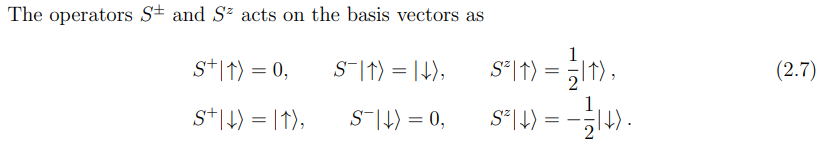

From the Heisenberg Hamiltonian spin chain of 

$$
\hat{H} = \sum_{n=1}^{L}  \bigg(J_{x} S_{n}^{x}S_{n+1}^{x} + J_{y} S_{n}^{y}S_{n+1}^{y} + J_{z} S_{n}^{z}S_{n+1}^{z} \bigg)
$$

where if we take $J_x = J_y = 0, J_z \ne 0$ will be reduced to an Ising chain,

$$
\hat{H}_{Ising} = \sum_{n=1}^{L} J_{z} S_{n}^{z}S_{n+1}^{z}.
$$

we see that $S^{\alpha}_{n}$ only interacts with $S^{\alpha}_{n+1}$ which is its nearest neighbor. We call such interaction the nearest neighboring interaction. If the Hamiltonian involve k-sites, we say the interacting range is k. The best studied spin chains
are the ones with $k=2$.

We will also define a boundary condition where $S^{\alpha}_{L+1} = S^{\alpha}_{1}$ called the periodic boundary condition.

A more general boundary condition would also add the following condition of $S^{\pm}_{L+1} = \kappa^{\pm} S^{\pm}_{1}$ on top of $S^{\alpha}_{L+1} = S^{\alpha}_{1}$

In [16]:
import numpy as np
from numpy import kron
from scipy.linalg import expm

# Define Pauli matrices and identity matrix
#SpinZ = np.array([[1, 0], [0, -1]], dtype=complex)
#IdMatrix = np.eye(2, dtype=complex)

def Hamiltonian_ISING_v2(N_spins, exchange_constant):
    """
    Constructs the Ising Hamiltonian with periodic boundary conditions.

    Parameters:
    N_spins (int): Number of spins (sites) in the chain.
    exchange_constant (float): Coupling constant for the sigma_z term.

    Returns:
    H : np.array
        The Hamiltonian matrix of the system.
    """
    # Initialize the Hamiltonian matrix
    H = np.zeros((2**N_spins, 2**N_spins), dtype=complex)
    
    # Loop over each spin site
    for i in range(N_spins):
        # Initialize as identity matrix
        Ising_term = 1
        for j in range(N_spins):
            if j == i:  # PauliZ at site i
                Ising_term = kron(Ising_term, SpinZ)
            elif j == (i + 1) % N_spins:  # PauliZ at site i+1 (with periodic boundary)
                Ising_term = kron(Ising_term, SpinZ)
            else:  # Identity elsewhere
                Ising_term = kron(Ising_term, IdMatrix)
        
        H += Ising_term  # Add this term to the Hamiltonian
    
    H *= exchange_constant  # Multiply by exchange constant
    
    return H


In [17]:
Hamiltonian_ISING_v2(5, 1)

array([[1.25+0.j, 0.  +0.j, 0.  +0.j, ..., 0.  +0.j, 0.  +0.j, 0.  +0.j],
       [0.  +0.j, 0.25+0.j, 0.  +0.j, ..., 0.  +0.j, 0.  +0.j, 0.  +0.j],
       [0.  +0.j, 0.  +0.j, 0.25+0.j, ..., 0.  +0.j, 0.  +0.j, 0.  +0.j],
       ...,
       [0.  +0.j, 0.  +0.j, 0.  +0.j, ..., 0.25+0.j, 0.  +0.j, 0.  +0.j],
       [0.  +0.j, 0.  +0.j, 0.  +0.j, ..., 0.  +0.j, 0.25+0.j, 0.  +0.j],
       [0.  +0.j, 0.  +0.j, 0.  +0.j, ..., 0.  +0.j, 0.  +0.j, 1.25+0.j]])

Now that we have the Hamiltonian, lets proceed to applying it to a unitary operator

In [18]:
from scipy.linalg import expm
def unitary_operator_ISING(Ising_Hamiltonian_term, time):
    # Check if Ising_Hamiltonian_term is a square matrix
    if Ising_Hamiltonian_term.shape[0] != Ising_Hamiltonian_term.shape[1]:
        raise ValueError("Ising_Hamiltonian_term must be a square matrix.")
    
    # Check if the matrix is of size 2^nQubits x 2^nQubits
    size = Ising_Hamiltonian_term.shape[0]
    if not (size & (size - 1) == 0 and size != 0):  # Check if size is a power of 2
        raise ValueError("The size of Ising_Hamiltonian_term must be 2^nQubits x 2^nQubits.")
    
    # Check if time is non-negative
    if time < 0:
        raise ValueError("Time must be non-negative.")
    
    #exponential_term = expm(1j * Ising_Hamiltonian_term * (time+1))
    exponential_term = expm(1j * Ising_Hamiltonian_term * time)
    return exponential_term

In [19]:
test_ham_ising = Hamiltonian_ISING_v2(4, 1)
unitary_operator_ISING(test_ham_ising, 1).shape

(16, 16)

In [20]:
def psi_initial_random_state_uniform(NSpins = 8, min_val = 0, max_val = 1):
    """
    Generate a row vector of random zeros and ones, and then each of the components are multiplied by a constant taken from a Gaussian ensemble
    for each of the components of the statevector.

    Parameters:
    NSpins (int): The length of the vector which corresponds to how many spins.

    Returns:
    numpy.ndarray: A row vector of random numbers from [min_val, max_val].
    """
    if not isinstance(NSpins, int) or NSpins <= 0:
        raise ValueError("The number of qubits must be a positive integer.")
    uniform_ensemble = np.random.uniform(min_val, max_val, size = (2**NSpins, 1))
    normalized_uniform_ensemble = uniform_ensemble / np.linalg.norm(uniform_ensemble)
    #print(f"The gaussian ensemble for each of the components: \n", gaussian_ensemble)
    return normalized_uniform_ensemble

In [21]:
def ISING_time_evolving_EE(NSpins, exchange_const, n_A, final_time, interval_time, initial_state_condition = True):
    
    # Make a time step for later use, when calculating the entanglement entropy of the SYK
    # model as a function of time.
    time_steps = np.arange(0, (final_time + interval_time), interval_time)

    # And make a list for the result of the EE as a function of time
    unitary_operator_dict = {}
    EE_final_list = []

    # Make the initial state
    #ISING_initial_state = initialize_ground_state(N_spins=NSpins, all_up=initial_state_condition)
    ISING_initial_state = psi_initial_random_state_uniform(NSpins=NSpins, min_val=0, max_val=1)

    # Initiate and define the Hamiltonian for Ising model
    H_ising = Hamiltonian_ISING_v2(N_spins=NSpins, exchange_constant=exchange_const)
    
    # A time loop over the time ran from the initial time to final time.
    for time_i in time_steps:
        unitary_operator_dict[time_i] = unitary_operator_ISING(H_ising, time=time_i) @ ISING_initial_state

    for time, statevectors in unitary_operator_dict.items():
        final_ee = Entanglement_Entropy_COMBINED_uniform(statevectors, n_A)
        EE_final_list.append(final_ee)
        
    print(EE_final_list)
    plot_EE_vs_time(time_steps, EE_final_list)

    return 


[(0.3885365887452783-0j), (0.388823800583216+3.110551459293798e-19j), (0.38968376285771955+2.0058897949698988e-19j), (0.39111147812557323-7.855907607226325e-19j), (0.3930986908452031-4.7591873534929075e-18j), (0.395633995204271+1.6211757863381157e-18j), (0.3987029813057043-2.802524965987206e-19j), (0.40228841530367043-6.535142806422025e-18j), (0.4063704482989982+2.0271742715238006e-19j), (0.41092684831219695-2.3638183754686893e-20j), (0.4159332494537311-1.2209350704829111e-17j), (0.4213634124845477+3.2262833264456503e-18j), (0.4271894912664498+1.2296877054446322e-17j), (0.4333823000913153+1.8540414453360753e-19j), (0.4399115774951639-1.1896095901227604e-17j), (0.4467462428531195-1.6259496060111086e-18j), (0.45385464276531085-1.9528786239845542e-19j), (0.46120478494086176-3.3676885735070383e-19j), (0.4687645579363108+1.2931065819993894e-18j), (0.47650193568484417-2.83084854342244e-19j), (0.4843851662516151-3.1508161330117017e-19j), (0.49238294466355415+9.485349234903964e-18j), (0.500464

c:\Users\Acer Aspire 5\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


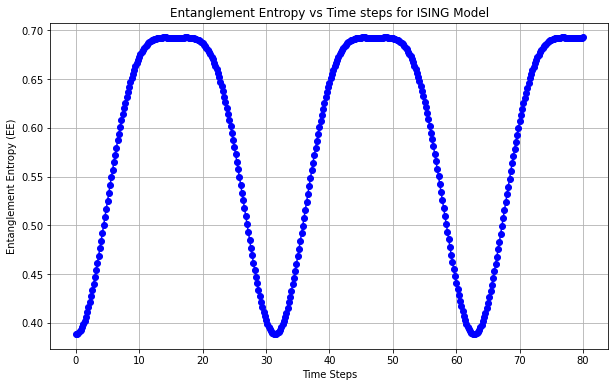

In [22]:
ISING_time_evolving_EE(NSpins=10, exchange_const=0.2, n_A=1, final_time=80, interval_time=0.2, initial_state_condition=True)

In [23]:
(1/6) * np.log(10)

0.3837641821656743

[(0.3839741183864491-0j), (0.3850882243479169+8.302102341710628e-19j), (0.3884053872847628-1.8895624241039436e-19j), (0.39385143679519785-1.7779817691217418e-19j), (0.40130691275850894+2.9176911367479575e-19j), (0.4106127873361456-1.3233081823035266e-18j), (0.4215775695479739-9.059831031129111e-18j), (0.4339851244360581-1.1705134844146764e-17j), (0.4476025958420614-5.646324316859089e-18j), (0.4621879514643312+2.781383163061968e-18j), (0.4774968259747806-2.591814218367586e-18j), (0.49328848611167375+2.0853139344509394e-18j), (0.5093308596579457-5.228171872817621e-19j), (0.5254046513017538-1.7724778607927578e-17j), (0.5413066155321785-8.296440550362653e-18j), (0.556852077571001+5.794709617003313e-18j), (0.5718767963949644-3.945797811921908e-18j), (0.5862382565099786+6.511125619203853e-20j), (0.5998164627517482-5.664595659918506e-19j), (0.6125142986103697-1.6966831380926813e-19j), (0.6242574955461011+1.3838105218623128e-17j), (0.634994249593321+2.599335568462556e-18j), (0.6446945127117453

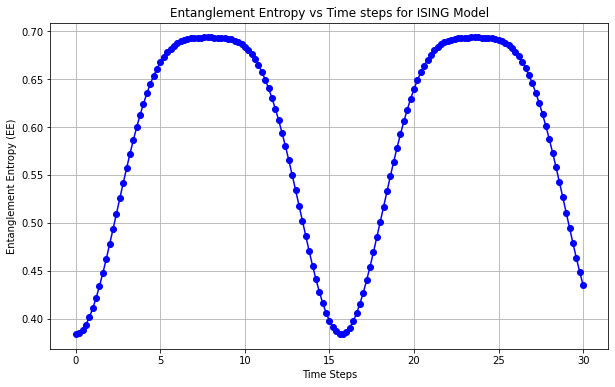

In [24]:
ISING_time_evolving_EE(NSpins=10, exchange_const=0.4, n_A=1, final_time=30, interval_time=0.2, initial_state_condition=True)

Lets try adding an external magnetic field.

In [25]:
import numpy as np
from numpy import kron
from scipy.linalg import expm

# Define Pauli matrices and identity matrix
#SpinZ = np.array([[1, 0], [0, -1]], dtype=complex)
#SpinX = np.array([[0, 1], [1, 0]], dtype=complex)
#IdMatrix = np.eye(2, dtype=complex)

def Hamiltonian_ISING_v3(N_spins, exchange_constant, external_field):
    """
    Constructs the Ising Hamiltonian with periodic boundary conditions,
    including an external magnetic field in the x-direction.

    Parameters:
    N_spins (int): Number of spins (sites) in the chain.
    exchange_constant (float): Coupling constant for the sigma_z term.
    external_field (float): External magnetic field in the x direction.

    Returns:
    H : np.array
        The Hamiltonian matrix of the system.
    """
    # Initialize the Hamiltonian matrix
    H = np.zeros((2**N_spins, 2**N_spins), dtype=complex)
    
    # Loop over each spin site for the Ising interaction term
    for i in range(N_spins):
        # Initialize as identity matrix
        Ising_term = 1
        for j in range(N_spins):
            if j == i:  # PauliZ at site i
                Ising_term = kron(Ising_term, SpinZ)
            elif j == (i + 1) % N_spins:  # PauliZ at site i+1 (with periodic boundary)
                Ising_term = kron(Ising_term, SpinZ)
            else:  # Identity elsewhere
                Ising_term = kron(Ising_term, IdMatrix)
        
        H += Ising_term  # Add this term to the Hamiltonian
    
    # Multiply by exchange constant
    H *= exchange_constant
    
    # Add the external magnetic field term
    for i in range(N_spins):
        Magnetic_field_term = 1
        for j in range(N_spins):
            if j == i:  # PauliX at site i
                Magnetic_field_term = kron(Magnetic_field_term, SpinX)
            else:  # Identity elsewhere
                Magnetic_field_term = kron(Magnetic_field_term, IdMatrix)
        
        H += external_field * Magnetic_field_term
    
    return H


In [26]:

# Example usage:
N_spins = 3
exchange_constant = 1.0
external_field = 0.5
H = Hamiltonian_ISING_v3(N_spins, exchange_constant, external_field)
print(H)

[[ 0.75+0.j  0.25+0.j  0.25+0.j  0.  +0.j  0.25+0.j  0.  +0.j  0.  +0.j
   0.  +0.j]
 [ 0.25+0.j -0.25+0.j  0.  +0.j  0.25+0.j  0.  +0.j  0.25+0.j  0.  +0.j
   0.  +0.j]
 [ 0.25+0.j  0.  +0.j -0.25+0.j  0.25+0.j  0.  +0.j  0.  +0.j  0.25+0.j
   0.  +0.j]
 [ 0.  +0.j  0.25+0.j  0.25+0.j -0.25+0.j  0.  +0.j  0.  +0.j  0.  +0.j
   0.25+0.j]
 [ 0.25+0.j  0.  +0.j  0.  +0.j  0.  +0.j -0.25+0.j  0.25+0.j  0.25+0.j
   0.  +0.j]
 [ 0.  +0.j  0.25+0.j  0.  +0.j  0.  +0.j  0.25+0.j -0.25+0.j  0.  +0.j
   0.25+0.j]
 [ 0.  +0.j  0.  +0.j  0.25+0.j  0.  +0.j  0.25+0.j  0.  +0.j -0.25+0.j
   0.25+0.j]
 [ 0.  +0.j  0.  +0.j  0.  +0.j  0.25+0.j  0.  +0.j  0.25+0.j  0.25+0.j
   0.75+0.j]]


In [27]:
def ISING_time_evolving_EE_v2(NSpins, exchange_const, n_A, final_time, interval_time, ext_field_str):
    
    # Make a time step for later use, when calculating the entanglement entropy of the SYK
    # model as a function of time.
    time_steps = np.arange(0, (final_time + interval_time), interval_time)

    # And make a list for the result of the EE as a function of time
    unitary_operator_dict = {}
    EE_final_list = []

    # Make the initial state
    #ISING_initial_state = initialize_ground_state(N_spins=NSpins, all_up=initial_state_condition)
    ISING_initial_state = psi_initial_random_state_uniform(NSpins=NSpins, min_val=0, max_val=1)

    # Initiate and define the Hamiltonian for Ising model
    H_ising = Hamiltonian_ISING_v3(N_spins=NSpins, exchange_constant=exchange_const, external_field=ext_field_str)
    
    # A time loop over the time ran from the initial time to final time.
    for time_i in time_steps:
        unitary_operator_dict[time_i] = unitary_operator_ISING(H_ising, time=time_i) @ ISING_initial_state

    for time, statevectors in unitary_operator_dict.items():
        final_ee = Entanglement_Entropy_COMBINED_uniform(statevectors, n_A)
        EE_final_list.append(final_ee)
        
    print(EE_final_list)
    plot_EE_vs_time(time_steps, EE_final_list)

    return 


[(0.38112030209166353-0j), (0.3817233338456951+4.94105229806341e-18j), (0.38351581514737254+4.5945179748895615e-18j), (0.3864491544624884+1.2864241167934056e-17j), (0.3904463554389152+8.678856860793311e-18j), (0.3954074126317224-1.6197384878664977e-18j), (0.4012158099084965+2.3836857672013045e-18j), (0.40774525098993075-7.22127994518578e-19j), (0.41486609625488896-2.3631545877562434e-18j), (0.42245048441421496+1.436394319703253e-17j), (0.43037626058977585-5.193484359395894e-18j), (0.43852933170882524+1.4742386526773971e-18j), (0.4468046944130124+6.177850274157594e-21j), (0.45510642881944485-2.7778832614158736e-18j), (0.46334704795736376+2.716261660635551e-18j), (0.47144659221203383-1.3470454396596908e-18j), (0.4793317902484914+7.297820829002555e-20j), (0.48693549677255954+8.887471677290804e-18j), (0.4941964909297957+4.887340409318254e-18j), (0.5010596033930625+1.0526480861177662e-18j), (0.5074760556432005+1.2179841859926535e-18j), (0.5134038533096095-1.226647945241598e-19j), (0.5188080

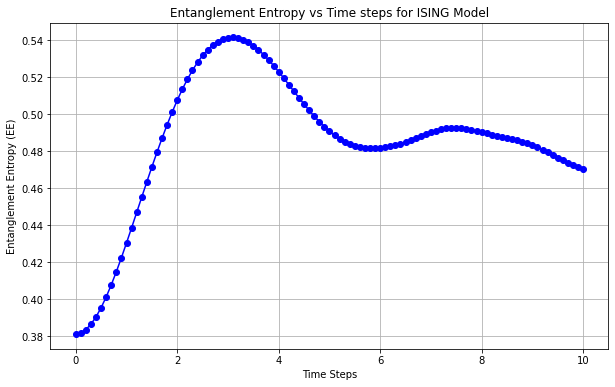

In [28]:
ISING_time_evolving_EE_v2(NSpins=10, exchange_const=0.5, n_A=1, final_time=10, interval_time=0.1, ext_field_str=0.5)

Lets do this manually,

In [29]:
import numpy as np
from numpy import kron
from scipy.linalg import expm

# Define Pauli matrices and identity matrix
#SpinZ = np.array([[1, 0], [0, -1]], dtype=complex)
#SpinX = np.array([[0, 1], [1, 0]], dtype=complex)
#IdMatrix = np.eye(2, dtype=complex)

def Hamiltonian_ISING_v5(N_spins, exchange_constant, external_field):
    """
    Constructs the Ising Hamiltonian with periodic boundary conditions,
    including an external magnetic field in the x-direction.

    Parameters:
    N_spins (int): Number of spins (sites) in the chain.
    exchange_constant (float): Coupling constant for the sigma_z term.
    external_field (float): External magnetic field in the x direction.

    Returns:
    H : np.array
        The Hamiltonian matrix of the system.
    """
    # Initialize the Hamiltonian matrix
    H = np.zeros((2**N_spins, 2**N_spins), dtype=complex)
    
    # Loop over each spin site for the Ising interaction term
    for i in range(1, N_spins+1):
        # Initialize as identity matrix
        Ising_term = 1
        for j in range(1, N_spins+1):
            if i == j:  # PauliZ at site i
                Ising_term = kron(Ising_term, SpinZ) 
            elif i == (j+1) % N_spins:
                Ising_term = kron(Ising_term, SpinZ)
            else :
                Ising_term = kron(Ising_term, IdMatrix)
        
        H += Ising_term  # Add this term to the Hamiltonian
    
    # Multiply by exchange constant
    H *= exchange_constant 
    
    return H


In [42]:
np.log(-1)

C:\Users\Acer Aspire 5\AppData\Local\Temp\ipykernel_7252\153577755.py:1: RuntimeWarning: invalid value encountered in log
  np.log(-1)


nan

In [30]:
def ISING_time_evolving_EE_v3(NSpins, exchange_const, n_A, final_time, interval_time, ext_field_str):
    
    # Make a time step for later use, when calculating the entanglement entropy of the SYK
    # model as a function of time.
    time_steps = np.arange(0, (final_time + interval_time), interval_time)

    # And make a list for the result of the EE as a function of time
    unitary_operator_dict = {}
    EE_final_list = []

    # Make the initial state
    #ISING_initial_state = initialize_ground_state(N_spins=NSpins, all_up=initial_state_condition)
    ISING_initial_state = psi_initial_random_state_uniform(NSpins=NSpins, min_val=0, max_val=1)

    # Initiate and define the Hamiltonian for Ising model
    H_ising = Hamiltonian_ISING_v5(N_spins=NSpins, exchange_constant=exchange_const, external_field=ext_field_str)
    print(H_ising.shape)
    # A time loop over the time ran from the initial time to final time.
    for time_i in time_steps:
        unitary_operator_dict[time_i] = unitary_operator_ISING(H_ising, time=time_i) @ ISING_initial_state

    for time, statevectors in unitary_operator_dict.items():
        final_ee = Entanglement_Entropy_COMBINED_uniform(statevectors, n_A)
        EE_final_list.append(final_ee)
        
    print(EE_final_list)
    plot_EE_vs_time(time_steps, EE_final_list)

    return 


(32, 32)
[(0.2447264403269417-0j), (0.2519868538470103+2.2661134230153086e-18j), (0.2727745484256395-7.112199652643845e-18j), (0.3044830965622333+8.080433735289453e-18j), (0.3437029710610949-7.281966427895431e-18j), (0.38695327168710736+5.735590813891216e-18j), (0.4311267018038386+3.3469544128556508e-18j), (0.4736969126036229-1.0890483988622842e-17j), (0.5127855584880309+6.579155034047626e-19j), (0.5471516287028915-5.219667824190679e-18j), (0.576132484438493+7.546113130848069e-19j), (0.5995497073763295+2.08721890090184e-18j), (0.6175880078029506-2.725521024044139e-18j), (0.6306563576349026-1.0160782976816955e-18j), (0.6392437459170136+2.8350445798085655e-19j), (0.6437852123795279+5.654892593766896e-19j), (0.644555239410243-4.3234456823668954e-19j), (0.6416037893867834-4.0897821501874713e-19j), (0.6347448610975872+6.000790164681765e-19j), (0.6235993864310115-9.885031696329053e-19j), (0.6076857258224284+2.414256619422038e-18j), (0.5865443109460271-5.925293131995601e-19j), (0.559879657601

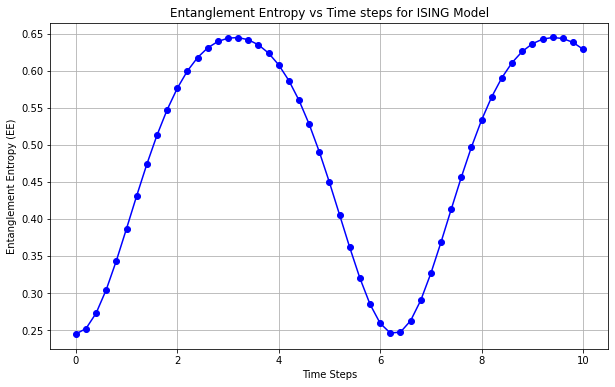

In [31]:
ISING_time_evolving_EE_v3(5, 1, 1, 10, 0.2, 1)

In [32]:
np.log(8)

2.0794415416798357

WITH QUTIP


In [33]:
import qutip as qt

In [34]:
eye2 = qt.qeye(2)
sz = qt.sigmaz()

def sigma_z_n(L,n):
    if n == 0 or n>L:
        raise ValueError("n ranges frpm 1 to L.")
    tensor_list = [eye2 for _ in range(L)]
    tensor_list[n-1] = sz
    return qt.tensor(*tensor_list)

In [35]:
sigma_z_n(4, 1)

Quantum object: dims=[[2, 2, 2, 2], [2, 2, 2, 2]], shape=(16, 16), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0. 

In [36]:
def Ham_ising_initial(L, Jz):
    Ham = 0
    for i in range(1, L-1):
        Ham += sigma_z_n(L, i) * sigma_z_n(L, i+1)
    Ham += sigma_z_n(L, L) * sigma_z_n(L, 1)
    return Jz/4 * Ham

In [37]:
Ham_ising_initial(4, 4)

Quantum object: dims=[[2, 2, 2, 2], [2, 2, 2, 2]], shape=(16, 16), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 3.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -3.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -3.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0. 

In [38]:
def ISING_time_evolving_EE_qutip(NSpins, exchange_const, n_A, final_time, interval_time):
    
    # Make a time step for later use, when calculating the entanglement entropy of the SYK
    # model as a function of time.
    time_steps = np.arange(0, (final_time + interval_time), interval_time)

    # And make a list for the result of the EE as a function of time
    unitary_operator_dict = {}
    EE_final_list = []

    # Make the initial state
    #ISING_initial_state = initialize_ground_state(N_spins=NSpins, all_up=initial_state_condition)
    ISING_initial_state = psi_initial_random_state_uniform(NSpins=NSpins, min_val=0, max_val=1)
    print(ISING_initial_state.shape)

    # Initiate and define the Hamiltonian for Ising model
    H_ising = Ham_ising_initial(NSpins, exchange_const).full()
    print(H_ising.shape)
    
    # A time loop over the time ran from the initial time to final time.
    for time_i in time_steps:
        unitary_operator_dict[time_i] = unitary_operator_ISING(H_ising, time=time_i) @ ISING_initial_state

    for time, statevectors in unitary_operator_dict.items():
        final_ee = Entanglement_Entropy_COMBINED_uniform(statevectors, n_A)
        EE_final_list.append(final_ee)
        
    print(EE_final_list)
    plot_EE_vs_time(time_steps, EE_final_list)

    return 


(1024, 1)
(1024, 1024)
[(0.3745417408643939-0j), (0.40324520576746403+8.548814868406055e-19j), (0.47478542168915183+1.3028370748242347e-18j), (0.5585890374510305-6.231518541043818e-18j), (0.6283765168398738+1.4886655011231766e-18j), (0.6715911552634397-1.3441406445974952e-19j), (0.6897214421657614+2.2845465245343747e-19j), (0.6932053979010331-4.736800815342409e-20j), (0.6930742177493838+7.133831682513174e-20j), (0.69296974456007-7.82363419754877e-18j), (0.6864970989482246+2.0344088413654083e-18j), (0.6618618626768196+1.4498491347086617e-19j), (0.6104736392409362+7.075476897369713e-19j), (0.5346187059425236+2.0640804093005207e-20j), (0.4512037493127141-5.93405613215534e-21j), (0.38927743309734597-7.8888271211063e-19j), (0.3771007603909037-1.2372072911669885e-18j), (0.42097370511393073+5.2108376390706165e-20j), (0.49937251963264007-8.87996576124555e-20j), (0.5812675016175869-3.4565919117495206e-18j), (0.643917479978585+5.134170862924095e-18j), (0.6791198815239221+6.728545316882258e-20j),

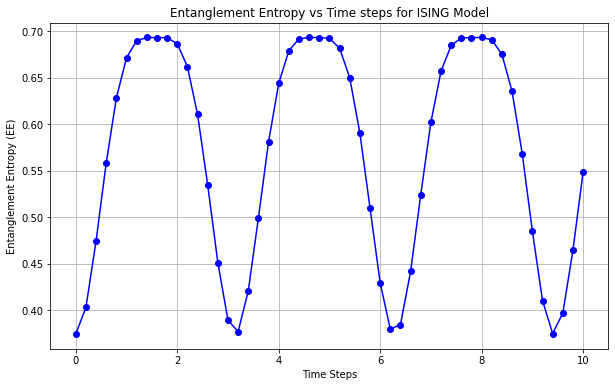

In [46]:
ISING_time_evolving_EE_qutip(NSpins=10, exchange_const=2, n_A=1, final_time=10, interval_time=0.2)

## Calculating the partition function of the Ising model.

We have the following Hamiltonian for a simplified Heisenberg model called the Ising mode,

$$
\hat{H}_{ising} = \sum_{n=1}^{L} J^{z} S^{z}_{n} S^{z}_{n+1},
$$

where if we have a total of $L$ spins to consider, the kronecker product of the spins are as follows

$$
S^{z}_{n}S^{z}_{n+1} = S^{z}_{n} \otimes S^{z}_{n+1} \otimes \mathbb{I} \cdots \mathbb{I}
$$

where the total length of the kronecker product will be $L$, and the dimension of matrix will be $2^L \times 2^L$.

From the definition of a partition function,

$$
Z = \sum_{s} e^{-\beta E(s)},
$$

where in this case, $E(s)$ here is hamiltonian of the Ising model for all possible configurations.

$$
\begin{equation}
\begin{split}
    Z &= e^{-\beta  [J^{z} \big(S^z_1 S^z_2 + S^z_2 S^z_3 + \cdots + S^z_{L-1}S^z{L} \big)]}
\end{split}
\end{equation}
$$